# Radial mode regression

## Contents
* [Task description](#Task-description)
* [Dataset preprocessing](#Dataset-preprocessing)
* [Model architecture](#Model-architecture)
* [Selection of hyperparameters](#Selection-of-hyperparameters)
* [Training](#Training)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Operating time](#Operating-time)
* [Criticism](#criticism)
* [Summary](#Summary)
* [Proposals for the improvement and further development](#Proposals-for-the-improvement-and-further- development)

## Task description
To predict a position of the radial mode according to the pressure derivative vs time data.

## Dataset preprocessing

For training and model performance assessment we use pressure derivative from two types of wells - VS and GRP.

Dataset consists of two parts: train (311 items) and test (90 items).
Each one consists of:
* an array of the pressure derivative of different length
* an array of times when the above measurements were taken
* a type of a pattern determined by an expert for some of the itemes
* a well type
* a position of the radial mode

Some imports:

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(".."))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from radial.batchflow import Dataset, FilesIndex, Pipeline, R, B, V, C, action, inbatch_parallel
from radial.batchflow.models.tf import TFModel
from radial.batchflow.models.tf.layers import conv_block

from radial.batchflow.research import Research, Option
from radial.batchflow.research.research import Executable

from radial.core import RadialBatch, RadialImagesBatch
from radial.core.radial_batch_tools import *

from research_utils import *
plt.style.use('ggplot')
%matplotlib inline

Dataset loading

In [2]:
train_data = Dataset(FilesIndex(path="./data_splited/train/*"), batch_class=RadialBatch)
test_data = Dataset(FilesIndex(path="./data_splited/test/*"), batch_class=RadialBatch)

We load data to an instance of Dataset class from Batchflow

In [7]:
sample_data = train_data.p.load(fmt='npz').next_batch(10)

In [8]:
sample_data.components

('time', 'derivative', 'rig_type', 'target', 'predictions')

Some examples of the initial data

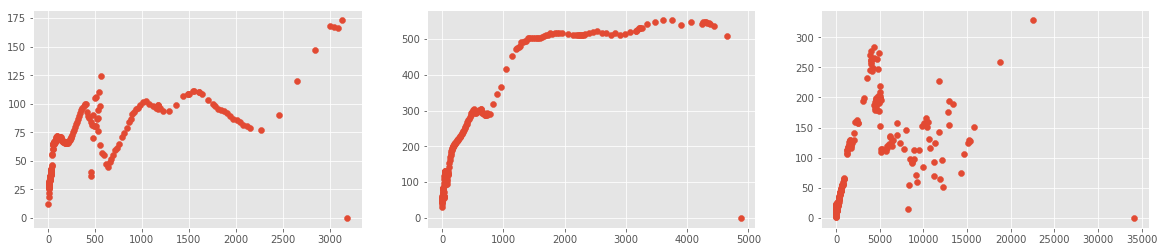

In [38]:
_, ax = plt.subplots(1, 3, figsize=(20, 4))
[ax[i].scatter(sample_data.time[i], sample_data.derivative[i]) for i in range(3)]
plt.show()

Pressure derivative data is noisy so we denoised the data beforehand using unsupervised method [Isolation forest](link). Сomparison of different approaches is [here](link)

In [2]:
ds_train = Dataset(FilesIndex(path="./data_splited/train_isol/*"), batch_class=RadialBatch)
ds_test = Dataset(FilesIndex(path="./data_splited/test_isol/*"), batch_class=RadialBatch)

In [3]:
sample_data = ds_train.p.load(fmt='npz').next_batch(10)

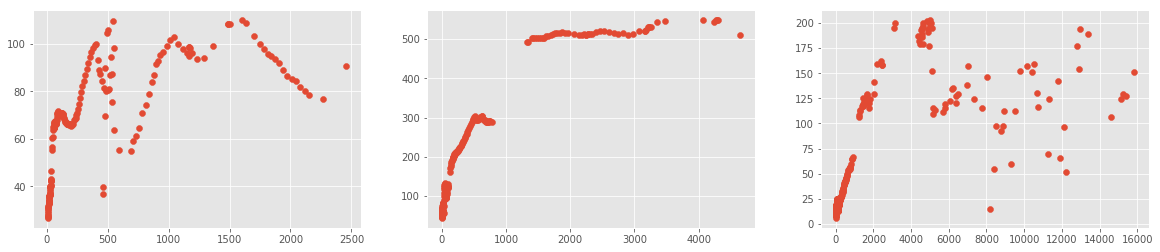

In [42]:
_, ax = plt.subplots(1, 3, figsize=(20, 4))
[ax[i].scatter(sample_data.time[i], sample_data.derivative[i]) for i in range(3)]
plt.show()

As you can see algorithm removed some of the single distant outliers that are not informative.

Distribution of radial mode value for train and test data:

In [50]:
train = ds_train.p.load(fmt='npz').next_batch(len(ds_train))
test = ds_train.p.load(fmt='npz').next_batch(len(ds_test))

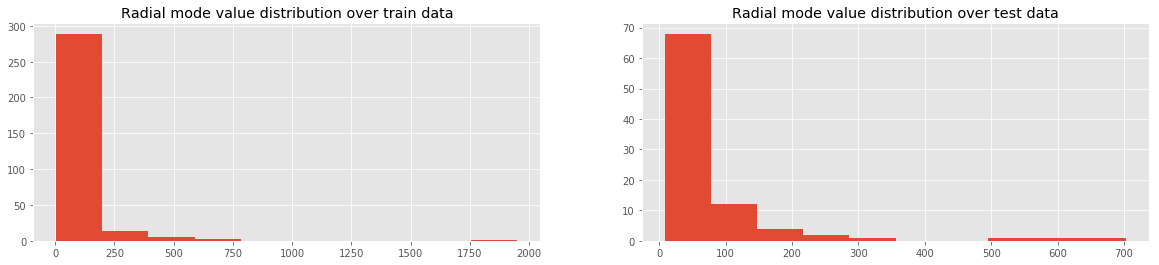

In [59]:
_, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].hist(train.target)
ax[0].set_title("Radial mode value distribution over train data")
ax[1].hist(test.target)
ax[1].set_title("Radial mode value distribution over test data")
plt.show()

Scale of the pressure derivative (and consequently the radial mode values) is different across different wells. Therefore in preprocessing pipeline we
normalize the pressure derivative data, time and radial mode value to the range [0, 1] by substracting min value and dividing by max-min.
Also we take logarithm of the pressure derivative, time and radial mode value and perform piece-wise interpolation to sample an equal number of points
to feed the model.

The whole preprocessing pipeline:

In [4]:
GRID_SIZE = 200

preprocess_ppl = (Pipeline()
                .init_variable('loss_history_dict', init_on_each_run=0)
                .hard_negative_sampling(statistics_name='loss_history_dict', fraction=0.33)
                .load(fmt='npz')
                .drop_negative()
                .apply_transform(log, src=['time', 'derivative', 'target'], dst=['log_time', 'log_derivative', 'log_target'])
                .normalize(src=['log_time', 'log_derivative'], dst=['log_norm_time', 'log_norm_derivative'],\
                           dst_range=[None, 'derivative_range'])
                .normalize(src='log_target', dst='log_norm_target', src_range='derivative_range')
                .expand_dims(src='log_norm_target')
                .make_grid_data(src=['log_norm_time', 'log_norm_derivative'], dst=['log_norm_time_grid', 'log_norm_derivative_grid'],
                                grid_size=GRID_SIZE)
                .make_array(src='log_norm_derivative_grid', dst='derivative_grid')
           )

## Model architecture

We use a convolutional neural network consisting of 3 identical blocks.
The network architecture can be described by layout `cna cna cna Pf`, where letters correspond to the following layers:
* `с` - 1d convolution
* `n` - batch normalisation
* `a` - activation
* `P` - global average pooling
* `f` - dense

Convolutional layer parameters `c`:
* ```filters```= 64 * 2**i, where i - block number, i=0, 1, 2.
* ```kernel_size``` = 3
* ```strides``` = 2
* ```padding``` = 'same'
* ```data_format``` = 'channels_last'
* ```activation``` = `None`

Pooling layer parameters `p`:
* ```pool_size``` = 2
* ```pool_strides``` = 1.

Activation layer parameters `a`:
* `activation` = `tf.nn.relu`

Dense layer parameters `dense`:
* `filters` = 10
* `activation` = `None`

Model description config:

In [6]:
model_config = {
    'inputs': dict(signals=dict(shape=(GRID_SIZE, 1)),
                             labels={'shape': (1), 'name': 'targets'}),
    'body': dict(layout='cna cna cna', filters=[64, 128, 256],
                 strides=2, kernel_size=3),    
    'head': dict(layout='Pf', units=1),
    'initial_block/inputs': 'signals',
    'loss': 'mse',
    'optimizer': ('MomentumOptimizer', {'learning_rate': 0.001, 'momentum': 0.5})}

## Selection of hyperparameters

The choice of this architecture (number of blocks and number of filters in convolutional layers) is motivated by the [research](https://github.com/analysiscenter/standards/blob/model/model_examples/classification_model/parameters_estimation.ipynb).

Other parameters such as an activation function and single block layout are chosen due to the common standards. 

## Training

We train our model using stochastic gradient descent. On each iteration we
* load mini-batch data
* update the weights 

Algorith of weights update (optimizer) is the Nesterov momentum with hyperparameters:
* ```learning_rate``` = 0.01
* ```mu``` = 0.5

The choice of optimizer hyperparameters is motivated by the [research](../../research_examples/model_training/optimizer_search.ipynb), as for they show the best convergence.

Loss - cross-entropy.

Dataset bypass:
* ```batch_size``` = 64
* ```n_epochs``` = 10.

Training pipeline:

In [8]:
train_ppl = (preprocess_ppl 
                 .init_variable('loss')
                 .init_variable('mean_loss_history', init_on_each_run=list)
                 .init_variable('loss_history', init_on_each_run=0)
                 .init_model('dynamic', TFModel, 'model', config=model_config)
                 .train_model('model', fetches=['loss', 'ConvModel/mean_squared_error/SquaredDifference:0'],
                           feed_dict={'signals': B('derivative_grid'),
                                      'labels': B('log_norm_target')}, 
                           save_to=[V('loss'), V('loss_history')], mode='w')
                 .update_variable('mean_loss_history', V('loss'), mode='a')
                 .update_loss_history_dict()
                 )

test_ppl = (preprocess_ppl 
                  .init_variable('loss', init_on_each_run=0)
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_variable('targets', init_on_each_run=list)
                  .init_variable('predictions', init_on_each_run=list)
                  .import_model('model', C('import_from'))
                  .predict_model('model', fetches=['loss', 'predictions'],
                               feed_dict={'signals': B('derivative_grid'),
                                          'labels': B('log_norm_target')},
                               save_to=[V('loss'), B('predictions')], mode='w')
                  .update_variable('loss_history', V('loss'), mode='a')
                  .denormalize(src='predictions', dst='denorm_predictions',
                               src_range='derivative_range')
                  .update_variable('targets', B('log_target'), mode='e')
                  .update_variable('predictions', B('denorm_predictions'), mode='e')
                )

Execute training

In [13]:
2000 * 16 / 311

102.89389067524115

In [ ]:
print('dsd')

In [14]:
!nvidia-smi

Fri Mar  1 13:18:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.78       Driver Version: 410.78       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:03:00.0 Off |                  N/A |
| 27%   31C    P8    10W / 180W |   7954MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
| 32%   48C    P2    40W / 180W |   7885MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [ ]:
BATCH_SIZE = 16

train_pipeline.run(BATCH_SIZE, n_epochs=160, drop_last=True, shuffle=True, bar=True)

In [ ]:
To analyse results of the model we use a custom metrics 

The loss function vs number of iterations:

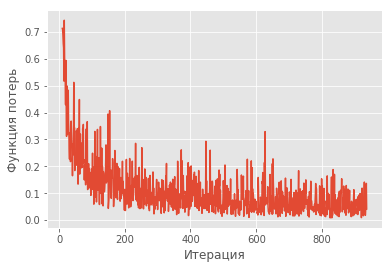

In [7]:
show_loss(train_pipeline.get_variable('loss_history'), skip=10)

## Inference

Prediction pipeline:

In [8]:
predict_template = (Pipeline()
                    .import_model('mnist_model', train_pipeline)
                    .init_variable("predictions", init_on_each_run=list)
                    .to_array()
                    .predict_model('mnist_model', fetches='proba',
                                   feed_dict={'images': B('images')},
                                   save_to=V('predictions'), mode="e"))

Execute prediction pipeline

In [9]:
predict_pipeline = ((predict_template << mnist.test)
                    .run(64, shuffle=False, n_epochs=1, drop_last=False, bar=True))

 99%|█████████▉| 156/157 [00:06<00:00, 23.95it/s]


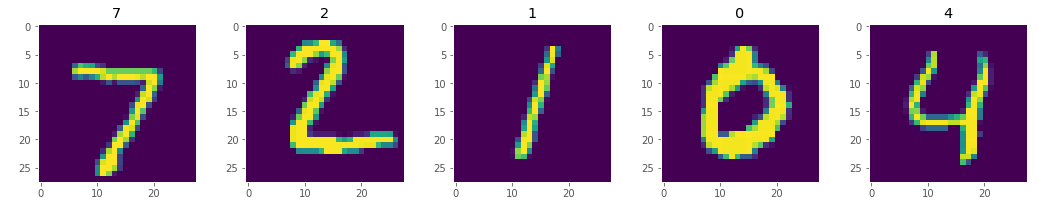

In [10]:
size = 5
y_pred = predict_pipeline.get_variable('predictions')
show_samples(test.to_array().images[:size, :, :, 0], labels=np.argmax(y_pred[:size], axis=1))

## Model evaluation

Quality metric, in this case, is ```accuracy``` on the test set.

Metric evaluation pipeline:

In [11]:
test_template = (Pipeline()
                 .import_model('mnist_model', train_pipeline)
                 .init_variable('predictions', init_on_each_run=list)
                 .init_variable('metrics', init_on_each_run=None)
                 .to_array()
                 .predict_model('mnist_model', fetches='proba', 
                                feed_dict={'images': B('images')},
                                save_to=V('predictions'))
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                 fmt='proba', axis=-1, save_to=V('metrics'), mode='u'))

In [12]:
test_pipeline = ((test_template << mnist.test)
                 .run(64, shuffle=False, n_epochs=1, drop_last=True, bar=True))

100%|██████████| 156/156 [00:07<00:00, 21.51it/s]


In [13]:
metrics = test_pipeline.get_variable('metrics')
print("Accuracy: %.3f" % metrics.evaluate('accuracy'))

Accuracy: 0.985


For model performance assessment an [experiment](./model_estimation.ipynb) was conducted on 20 model training launches from  scratch.

Research results loading and a distribution for `accuracy`:

In [14]:
df = Results(path='model_estimation_research').load()
values = df[df['name'] == 'test']['metrics'].apply(lambda x: x.evaluate('accuracy')).values

`Accuracy` histogram

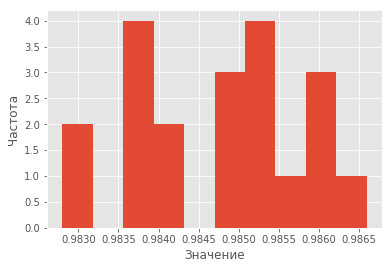

Среднее значение (медиана): 0.985


In [15]:
show_histogram(values)
print('Среднее значение (медиана): %.3f' % np.median(values))

Average value (median): 0.0985

```confusion_matrix``` on 10 classes (rows and columns are numbered from 0 до 9 corresponding to the numbers on
the images):

In [16]:
cfm = get_confusion_matrix(metrics)
print(cfm)

[[ 974    0    3    1    1    1    7    0    6    1]
 [   0 1127    2    0    0    0    4    2    0    0]
 [   2    1 1016    3    1    0    0    4    0    0]
 [   0    2    2  991    0    7    0    2    3    1]
 [   0    0    1    1  962    1    2    0    2    1]
 [   1    1    0    5    0  878    5    0    2    4]
 [   0    0    0    0    0    1  934    0    0    1]
 [   2    1    3    2    0    0    0 1011    0    4]
 [   0    1    3    3    3    1    4    0  951    4]
 [   0    0    0    2   13    1    0    8    9  992]]


 `Precision` Histogram for each class:

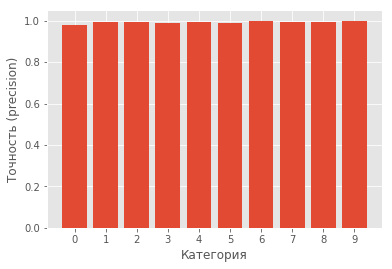

In [17]:
class_precision(cfm)

## Operating time

Device: CPU i7.

One train step on batch size 64 takes 200 ms. Training time is 32 s.

One image inference takes 3 ms, for batch size 64 - 44 ms.

## Criticism

To identify weak spots of the model we performed model prediction on the shifted images.
To do so we added an image shift step to the prediction pipeline. An image is shifted on a random number of pixels from the uniform distribution in [-5, 5]

In [18]:
template_criticism_pipeline = (
  Pipeline()
    .import_model("mnist_model", train_pipeline)
    .init_variable("predictions")
    .init_variable("metrics", init_on_each_run=None)
    .shift((R("randint", -5, 5), R("randint", -5, 5)))
    .to_array()
    .predict_model("mnist_model", fetches="predictions", save_to=V("predictions"),
                   feed_dict={"images": B("images")})
    .gather_metrics("class", targets=B("labels"), predictions=V("predictions"),
                    fmt="logits", axis=-1, save_to=V("metrics"), mode="u")
    .run(batch_size=64, n_epochs=1, drop_last=False, bar=True, lazy=True)
)

Run criticism pipeline

In [19]:
criticism_pipeline = (mnist.test >> template_criticism_pipeline).run()

 99%|█████████▉| 156/157 [00:07<00:00, 20.65it/s]


Compute `accuracy`

In [20]:
print("Accuracy: %.3f" % criticism_pipeline.get_variable("metrics").evaluate("accuracy"))

Accuracy: 0.810


Accuracy decreased by 20%, which means the model is sensitive to a shift.

## Summary

The model classifies images of size 28х28 with digits in greyscale. The average (median) model accuracy is 98.5%.


## Proposals for the improvement and further development

For robust classification improvement (relative to the shift of an image from the central position) we suggest to include augmentation to the training pipeline.